In [1]:
import matplotlib.pyplot as plt
from catboost import CatBoostRanker, Pool
from kaggle_hm.chart_model import filter_data
from copy import deepcopy
import numpy as np
import os
import seaborn as sns
import pandas as pd
from kaggle_hm.config import data_root, train_dates, test_dates
from kaggle_hm.evaluation import compute_precision
import kaggle_hm.als_model
from kaggle_hm.chart_model import age_chart

In [26]:
def calc_features(als_candidates, train: pd.DataFrame, customers: pd.DataFrame, items: pd.DataFrame) -> pd.DataFrame:
    train_nodup = train.drop_duplicates(subset=['customer_id', 'article_id'])
    candidates = als_candidates.merge(train_nodup[['customer_id', 'article_id', 't_dat']], on=['customer_id', 'article_id'], how='left')
    candidates['bought'] = candidates['t_dat'].notna().astype('int')
    candidates = candidates.drop(columns=['t_dat'])

    train_nodup = train.drop_duplicates(subset=['customer_id', 'product_code'])
    candidates = candidates.merge(train_nodup[['customer_id', 'product_code', 't_dat']], on=['customer_id', 'product_code'], how='left')
    candidates['bought_same_prod'] = candidates['t_dat'].notna().astype('int8')
    candidates = candidates.drop(columns=['t_dat'])
    # shopping frequency

    candidates = candidates.merge(customers[['customer_id', 'age']], on='customer_id', how='left')
    candidates = candidates.merge(items[['article_id', 'product_type_name', 'colour_group_name', 'department_name', 'section_name', 'garment_group_name']], on='article_id', how='left')

    return candidates

def rank_predictions(pred_df: pd.DataFrame, model: CatBoostRanker) -> pd.DataFrame:
    pred_df['prediction'] = model.predict(pred_df[model.feature_names_])
    pred_df['rank'] = pred_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

    relevant_items = pred_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
    return relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))


def get_item_stats(transactions, prediction_date):
    item_stats = (
        transactions
        .groupby('article_id', observed=True)
        .agg(
            total_cust=('customer_id', 'count'),
            uniq_customers=('customer_id', 'nunique'),
            min_dt=('t_dat', 'min'),
            max_dt=('t_dat', 'max'),
            days=('t_dat', 'nunique'),
            avg_price=('price', 'mean'),
            avg_age=('age', 'mean'),
            median_price=('price', 'median'),
            max_price=('price', 'max'),
            min_price=('price', 'min'),
        )
    ).reset_index()
    item_stats['item_age'] = 1 / (1 + (pd.to_datetime(prediction_date) - item_stats['min_dt']).dt.days)
    item_stats['daily_sales'] = item_stats['total_cust'] / item_stats['days']
    item_stats['monday_item'] = (item_stats['min_dt'].dt.dayofweek == 0).astype('int')
    item_stats['avg_per_customer'] = item_stats['total_cust'] / item_stats['uniq_customers']

    return item_stats

In [5]:
c = pd.read_parquet(data_root / 'clean' / 'customers.parquet')
c['age'] = c['age'].fillna(c['age'].mean())
c['age_group'] = pd.cut(c['age'], bins=[15, 21, 25, 30, 40, 50, 60, 100])
items = pd.read_parquet(data_root / 'clean' / 'articles.parquet')

df = pd.read_parquet(data_root / 'clean' / 'transactions.parquet')
df = df.merge(c[['customer_id', 'age', 'age_group']], on='customer_id')
df['product_code'] = df['article_id'].str[1:7].astype('int')

cols = [f'rel_{i + 1}' for i in range(12)]

In [6]:
features = ['score', 'bought', 'age', 'product_type_name', 'colour_group_name',
            'department_name', 'section_name', 'garment_group_name', 'total_cust',
            'item_age', 'monday_item', 'avg_per_customer', 'daily_sales']

In [7]:
delta = (pd.to_datetime('2020-09-08') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

train = filter_data(df, from_date='2020-09-01', to_date=train_dates['end'])

test = filter_data(df, from_date=test_dates['start'], to_date=test_dates['end'])
results = test.groupby('customer_id', observed=True).agg(bought=('article_id', set)).reset_index()
full_ds = filter_data(df, to_date=train_dates['end'])

t_cust = set(train['customer_id'].unique())
old_cust = set(full_ds['customer_id'].unique()) - t_cust
cold_cust = set(test['customer_id'].unique()) - old_cust - t_cust

In [ ]:
full_ds_pred = full_ds[full_ds['customer_id'].isin(test['customer_id'].unique())]

In [ ]:
pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='time', factors=256, iterations=50, regularization=0.01)
pipeline.fit(train)
candidates = pipeline.predict(full_ds_pred, N=100)
candidates = calc_features(candidates, train, c, items)
candidates.head()

In [27]:
candidates = pd.read_parquet(data_root / 'clean' / 'candidates.parquet').drop(columns=['price', 'item_id'])
candidates['product_code'] = candidates['article_id'].str[1:7].astype('int')

In [28]:
candidates.head()

,score,customer_id,article_id,is_relevant,product_code
0,0.046631,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813001,0,685813
72,0.011759,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0917606004,0,917606
71,0.011767,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0919741001,0,919741
70,0.011869,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685816001,0,685816
69,0.011914,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0791837002,0,791837


In [29]:
candidates = calc_features(candidates, train, c, items)
candidates.head()

,score,customer_id,article_id,is_relevant,product_code,bought,bought_same_prod,age,product_type_name,colour_group_name,department_name,section_name,garment_group_name
0,0.046631,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813001,0,685813,0,0,24.0,Sweater,Black,Heavy Basic Jersey,Men Underwear,Jersey Basic
1,0.011759,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0917606004,0,917606,0,0,24.0,Trousers,Dark Blue,Denim Trousers,Ladies Denim,Trousers Denim
2,0.011767,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0919741001,0,919741,0,0,24.0,Blouse,Black,Blouse,Womens Everyday Collection,Blouses
3,0.011869,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685816001,0,685816,0,0,24.0,T-shirt,White,Light Basic Jersey,Men Underwear,Jersey Basic
4,0.011914,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0791837002,0,791837,0,0,24.0,T-shirt,Black,Light Basic Jersey,Men Underwear,Jersey Basic


In [31]:
old_transactions = filter_data(df, from_date='2020-08-01', to_date='2020-08-31')
item_stats = get_item_stats(old_transactions, '2020-09-08')
candidates = candidates.merge(item_stats, on='article_id', how='left')

In [32]:
candidates.head()

,score,customer_id,article_id,is_relevant,product_code,bought,bought_same_prod,age,product_type_name,colour_group_name,...,days,avg_price,avg_age,median_price,max_price,min_price,item_age,daily_sales,monday_item,avg_per_customer
0,0.046631,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685813001,0,685813,0,0,24.0,Sweater,Black,...,31.0,0.016563,33.719529,0.016932,0.016932,0.006763,0.025641,17.322581,0.0,1.251748
1,0.011759,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0917606004,0,917606,0,0,24.0,Trousers,Dark Blue,...,25.0,0.049143,32.424995,0.050831,0.050831,0.038119,0.030303,8.920000,0.0,1.013636
2,0.011767,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0919741001,0,919741,0,0,24.0,Blouse,Black,...,29.0,0.032995,35.324801,0.033881,0.033881,0.016932,0.027027,22.034483,1.0,1.212524
3,0.011869,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0685816001,0,685816,0,0,24.0,T-shirt,White,...,31.0,0.008116,36.364017,0.008458,0.008458,0.001678,0.025641,15.419355,0.0,1.288410
4,0.011914,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,0791837002,0,791837,0,0,24.0,T-shirt,Black,...,17.0,0.016529,40.666667,0.016932,0.016932,0.013169,0.025641,2.294118,0.0,1.114286


In [33]:
from sklearn.model_selection import train_test_split

customers = candidates['customer_id'].unique()

train_customers, test_customers = train_test_split(customers, test_size=0.2, random_state=42)

In [34]:
train_df = candidates[candidates['customer_id'].isin(train_customers)].copy()
test_df = candidates[candidates['customer_id'].isin(test_customers)].copy()

X_train = train_df[features]
y_train = train_df['is_relevant']
queries_train = train_df['customer_id']

X_test = test_df[features]
y_test = test_df['is_relevant']
queries_test = test_df['customer_id']

In [35]:
train_pool = Pool(
    data=X_train,
    label=y_train,
    group_id=queries_train,
    cat_features=['product_type_name', 'colour_group_name', 'department_name', 'section_name', 'garment_group_name']
)

test_pool = Pool(
    data=X_test,
    label=y_test,
    group_id=queries_test,
    cat_features=['product_type_name', 'colour_group_name', 'department_name', 'section_name', 'garment_group_name']
)

default_parameters = {
    'iterations': 2000,
    'custom_metric': ['MAP:top=10', 'NDCG'],
    'verbose': True,
    'metric_period': 200,
    'task_type': 'GPU',
    'devices': '0-1',
    'random_seed': 0,
    'learning_rate': 0.01,
    'one_hot_max_size': 10
}

parameters = {}

In [36]:
def fit_model(loss_function, additional_params=None, train_pool=train_pool, test_pool=test_pool):
    parameters = deepcopy(default_parameters)
    parameters['loss_function'] = loss_function
    parameters['train_dir'] = loss_function

    if additional_params is not None:
        parameters.update(additional_params)

    model = CatBoostRanker(**parameters)
    model.fit(train_pool, eval_set=test_pool, plot=False)

    return model

In [37]:
model = fit_model('PairLogit')

Metric MAP:top=10 is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time
Metric NDCG:type=Base is not implemented on GPU. Will use CPU for metric computation, this could significantly affect learning time


0:	learn: 0.6896266	test: 0.6898040	best: 0.6898040 (0)	total: 308ms	remaining: 10m 16s
200:	learn: 0.5243497	test: 0.5343526	best: 0.5343526 (200)	total: 21.7s	remaining: 3m 14s
400:	learn: 0.5055182	test: 0.5196358	best: 0.5196358 (400)	total: 43.4s	remaining: 2m 53s
600:	learn: 0.4964317	test: 0.5140883	best: 0.5140883 (600)	total: 1m 5s	remaining: 2m 31s
800:	learn: 0.4900695	test: 0.5110636	best: 0.5110636 (800)	total: 1m 26s	remaining: 2m 10s
1000:	learn: 0.4850446	test: 0.5091215	best: 0.5091215 (1000)	total: 1m 48s	remaining: 1m 48s
1200:	learn: 0.4806432	test: 0.5076873	best: 0.5076873 (1200)	total: 2m 10s	remaining: 1m 26s
1400:	learn: 0.4766462	test: 0.5064413	best: 0.5064413 (1400)	total: 2m 32s	remaining: 1m 5s
1600:	learn: 0.4730125	test: 0.5055481	best: 0.5055481 (1600)	total: 2m 53s	remaining: 43.3s
1800:	learn: 0.4697000	test: 0.5048849	best: 0.5048849 (1800)	total: 3m 15s	remaining: 21.6s
1999:	learn: 0.4666985	test: 0.5043801	best: 0.5043801 (1999)	total: 3m 36s	rema

In [38]:
model.save_model(data_root / 'models' / 'pair_logit.model')

In [38]:
model.get_best_score()

{'learn': {'MAP:top=10': 0.05504552102823315, 'PairLogit': 0.4666984611968708},
 'validation': {'NDCG:type=Base': 0.8342444621128192,
  'MAP:top=10': 0.05381073687731285,
  'PairLogit': 0.5043800869783605}}

In [39]:
rec_df = rank_predictions(test_df, model)
comb = results.merge(rec_df, on='customer_id')
comb['prediction'] = comb['candidates']
comb = compute_precision(comb)
comb['precision'].mean()

0.03447645308171245

In [40]:
from catboost.utils import eval_metric

eval_metric(y_test.values, test_df['prediction'].values, 'MAP:top=12', group_id=queries_test.values)

[0.05464436524708995]

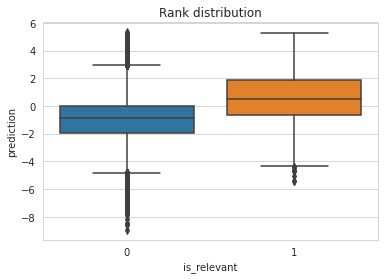

In [25]:
sns.boxplot(data=test_df, x='is_relevant', y='prediction')
plt.title('Rank distribution');

In [41]:
comb[comb['customer_id'].isin(t_cust)]['precision'].mean()

0.08443992954765481

In [42]:
comb[comb['customer_id'].isin(old_cust)]['precision'].mean()

0.019496353484972574

In [28]:
comb[comb['customer_id'].isin(cold_cust)]

,customer_id,bought,candidates,prediction,len_bought,rel_1,rel_2,rel_3,rel_4,rel_5,rel_6,rel_7,rel_8,rel_9,rel_10,rel_11,rel_12,rel_total,precision


In [29]:
comb[cols].sum()

rel_1     487
rel_2     334
rel_3     254
rel_4     209
rel_5     169
rel_6     156
rel_7     126
rel_8     127
rel_9     110
rel_10     96
rel_11     76
rel_12     81
dtype: int64

In [30]:
comb[cols].mean()

rel_1     0.037258
rel_2     0.025553
rel_3     0.019432
rel_4     0.015990
rel_5     0.012929
rel_6     0.011935
rel_7     0.009640
rel_8     0.009716
rel_9     0.008416
rel_10    0.007345
rel_11    0.005814
rel_12    0.006197
dtype: float64

count    1000.000000
mean        0.034410
std         0.004176
min         0.022146
25%         0.031540
50%         0.034294
75%         0.037180
max         0.048896
dtype: float64


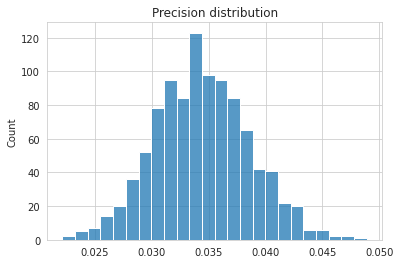

In [43]:
N = 1000
precisions = np.zeros(N)
for i in range(N):
    precisions[i] = comb.sample(n=1000)['precision'].mean()

print(pd.Series(precisions).describe())
sns.histplot(precisions)
plt.title('Precision distribution');

# submission

In [5]:
model = CatBoostRanker().load_model(fname=str(data_root / 'models' / 'pair_logit.model'))

In [6]:
submission = pd.read_csv('/data/sstamenov/kaggle-data/sample_submission.csv').drop(columns=['prediction'])
delta = (pd.to_datetime('2020-09-22') - df['t_dat']).dt.days
df['delta_weeks'] = 1 / (1 + np.power(delta // 7, 1))

In [7]:
submission.head()

,customer_id
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...


In [16]:
full_ds = filter_data(df, to_date='2020-09-22')
train = filter_data(df, '2020-09-15', '2020-09-22')

In [8]:
full_ds = filter_data(df, to_date='2020-09-22')
train = filter_data(df, '2020-09-15', '2020-09-22')

pipeline = kaggle_hm.als_model.MatrixFactorizationPipeline(min_items=1, min_customers=1, cell_value='time', factors=256, iterations=50, regularization=0.01)
pipeline.fit(train)
rec_df = pipeline.predict(full_ds, N=100)

#items 18684
#customers 75481


  0%|          | 0/50 [00:00<?, ?it/s]

In [9]:
rec_df = calc_features(rec_df, train, c, items)

In [10]:
old_transactions = filter_data(df, from_date='2020-08-24', to_date='2020-09-22')
item_stats = get_item_stats(old_transactions, '2020-09-22')
rec_df = rec_df.merge(item_stats, on='article_id', how='left')

In [11]:
rec_df.to_parquet(data_root / 'clean' / 'X_pred.parquet')

In [8]:
rec_df = pd.read_parquet(data_root / 'clean' / 'X_pred.parquet')

In [9]:
X_pred = rec_df[features]

In [10]:
X_pred.head()

,score,bought,age,product_type_name,colour_group_name,department_name,section_name,garment_group_name,total_cust,item_age,monday_item,avg_per_customer,daily_sales
0,0.381181,1,24.0,Jacket,Greyish Beige,Ladies Sport Woven,Ladies H&M Sport,Unknown,382,0.033333,1,1.197492,13.172414
1,0.276099,0,24.0,Hoodie,Black,Ladies Sport Bras,Ladies H&M Sport,Jersey Fancy,781,0.033333,1,1.199693,26.033333
2,0.194820,0,24.0,Hoodie,Green,Ladies Sport Bras,Ladies H&M Sport,Jersey Fancy,232,0.066667,0,1.094340,15.466667
3,0.193336,0,24.0,Hoodie,Light Pink,Ladies Sport Bras,Ladies H&M Sport,Jersey Fancy,432,0.033333,1,1.119171,14.400000
4,0.169497,0,24.0,Jacket,Pink,Ladies Sport Woven,Ladies H&M Sport,Unknown,77,0.045455,0,1.054795,3.666667


In [11]:
predictions = model.predict(X_pred)
rec_df['prediction'] = predictions
rec_df['rank'] = rec_df.groupby('customer_id')['prediction'].rank(ascending=False, method='first')

relevant_items = rec_df.query('rank <= 12').sort_values(['customer_id', 'rank'], ascending=True)
pred_df = (
    relevant_items.groupby('customer_id', observed=True).agg(candidates=('article_id', list))
)

In [12]:
pred_df.shape[0]

1105000

In [14]:
submission = submission.merge(c[['customer_id', 'age_group']], on='customer_id', how='left')

In [17]:
top12_age_pred = age_chart(train)
submission = submission.merge(pred_df, on='customer_id', how='left')
submission = submission.merge(top12_age_pred, on='age_group', how='left').drop(columns=['age_group'])
submission['prediction'] = submission['candidates'].combine_first(submission['naive_pred'])

In [18]:
submission.head()

,customer_id,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0779781015, 0568601043, 0568601006, 056859700...","[0751471001, 0923758001, 0924243001, 092424300...","[0779781015, 0568601043, 0568601006, 056859700..."
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0673677002, 0739590027, 0351484039, 059092800...","[0924243001, 0918522001, 0924243002, 091552900...","[0673677002, 0739590027, 0351484039, 059092800..."
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321007, 0805000001, 0805000007, 080500000...","[0924243001, 0918522001, 0924243002, 091552900...","[0794321007, 0805000001, 0805000007, 080500000..."
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...","[0924243001, 0928206001, 0930380001, 092424300..."
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0730683050, 0791587001, 089615200...","[0924243001, 0928206001, 0930380001, 092424300...","[0896152002, 0730683050, 0791587001, 089615200..."


In [19]:
submission.shape[0]

1371980

In [20]:
submission['prediction'] = submission['prediction'].apply(lambda _: ' '.join(_))

In [21]:
submission.head()

,customer_id,candidates,naive_pred,prediction
0,00000dbacae5abe5e23885899a1fa44253a17956c6d1c3...,"[0779781015, 0568601043, 0568601006, 056859700...","[0751471001, 0923758001, 0924243001, 092424300...",0779781015 0568601043 0568601006 0568597006 07...
1,0000423b00ade91418cceaf3b26c6af3dd342b51fd051e...,"[0673677002, 0739590027, 0351484039, 059092800...","[0924243001, 0918522001, 0924243002, 091552900...",0673677002 0739590027 0351484039 0590928001 08...
2,000058a12d5b43e67d225668fa1f8d618c13dc232df0ca...,"[0794321007, 0805000001, 0805000007, 080500000...","[0924243001, 0918522001, 0924243002, 091552900...",0794321007 0805000001 0805000007 0805000008 07...
3,00005ca1c9ed5f5146b52ac8639a40ca9d57aeff4d1bd2...,NaN,"[0924243001, 0928206001, 0930380001, 092424300...",0924243001 0928206001 0930380001 0924243002 09...
4,00006413d8573cd20ed7128e53b7b13819fe5cfc2d801f...,"[0896152002, 0730683050, 0791587001, 089615200...","[0924243001, 0928206001, 0930380001, 092424300...",0896152002 0730683050 0791587001 0896152001 07...


In [22]:
submission[['customer_id', 'prediction']].to_csv('/data/sstamenov/kaggle-data/output/implicit_time_rank_ftrs_submission.csv', index=False)